# Classificação de Anfibios pelo coaxar

In [ ]:
# Importação das bibliotecas utilizadas

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import time


## Importação do banco de dados e pré-processamento

In [ ]:
# Abertura do arquivo de banco de dados

arquivo = "Frogs_MFCCs.csv"
dataset = pd.read_csv(arquivo)
print(dataset.head(2))

   MFCCs_ 1  MFCCs_ 2  MFCCs_ 3  MFCCs_ 4  MFCCs_ 5  MFCCs_ 6  MFCCs_ 7  \
0       1.0  0.152936 -0.105586  0.200722  0.317201  0.260764  0.100945   
1       1.0  0.171534 -0.098975  0.268425  0.338672  0.268353  0.060835   

   MFCCs_ 8  MFCCs_ 9  MFCCs_10  ...  MFCCs_17  MFCCs_18  MFCCs_19  MFCCs_20  \
0 -0.150063 -0.171128  0.124676  ... -0.108351 -0.077623 -0.009568  0.057684   
1 -0.222475 -0.207693  0.170883  ... -0.090974 -0.056510 -0.035303  0.020140   

   MFCCs_21  MFCCs_22           Family      Genus         Species  RecordID  
0  0.118680  0.014038  Leptodactylidae  Adenomera  AdenomeraAndre         1  
1  0.082263  0.029056  Leptodactylidae  Adenomera  AdenomeraAndre         1  

[2 rows x 26 columns]


In [ ]:
# Divisão entre entradas e saídas

entradas = dataset.iloc[ :, 0:22]
tamanho_entrada = entradas.shape[1]

saida_familia = dataset['Family']
saida_genero = dataset['Genus']
saida_especie = dataset['Species']

# Normalizando as saídas de texto
label_encoder = LabelEncoder()

saida_familia = label_encoder.fit_transform(saida_familia)
saida_genero = label_encoder.fit_transform(saida_genero)
saida_especie = label_encoder.fit_transform(saida_especie)

In [ ]:
# Pre processamento da divisão entre conjuntos de treinamento e teste

X_train, X_test, y_familia_train, y_familia_test, y_genero_train, y_genero_test, y_especie_train, y_especie_test = train_test_split(
    entradas, saida_familia, saida_genero, saida_especie, test_size=0.3, random_state=0)

## A rede neural

In [ ]:
# Escolha do modelo

modelo_familia = Sequential()
modelo_genero = Sequential()
modelo_especie = Sequential()

# Adicionar as camadas à rede neural
modelo_familia.add(Dense(32, input_dim=tamanho_entrada, activation='relu'))
modelo_familia.add(Dense(16, activation='relu'))
modelo_familia.add(Dense(4,  activation='softmax'))  # 4 familias diferentes -- Camada de saída

modelo_genero.add(Dense(32, input_dim=tamanho_entrada, activation='relu'))
modelo_genero.add(Dense(16, activation='relu'))
modelo_genero.add(Dense(8,  activation='softmax'))  # 8 generos diferentes -- Camada de saída

modelo_especie.add(Dense(32, input_dim=tamanho_entrada, activation='relu'))
modelo_especie.add(Dense(16, activation='relu'))
modelo_especie.add(Dense(10, activation='softmax'))  # 10 espécies diferentes -- Camada de saída

### Compilação do modelo padrão

In [ ]:
# Taxa de aprendizado
learning_rate=0.001

# Tamanho do lote de dados
tamanho_lote=32

# Parar o treinamento caso a diferença do erro seja menor que um determinado valor
early_stopping_famila = EarlyStopping(monitor='loss',           # Monitorar a perda no conjunto de validação
                                      min_delta=0.001,          # Mudança mínima para ser considerada uma melhora
                                      patience=5,               # Número de épocas sem melhora antes de parar
                                      verbose=1,                # Exibir mensagens de log
                                      mode='min',               # Interromper quando a perda não diminui mais
                                      baseline=None,            # Baseline para comparação
                                      restore_best_weights=True)  # Restaurar os pesos do modelo quando parar

early_stopping_genero = EarlyStopping(monitor='loss',
                                      min_delta=0.001,
                                      patience=5,
                                      verbose=1,
                                      mode='min',
                                      baseline=None,
                                      restore_best_weights=True)

early_stopping_especie = EarlyStopping(monitor='loss',
                                      min_delta=0.001,
                                      patience=5,
                                      verbose=1,
                                      mode='min',
                                      baseline=None,
                                       restore_best_weights=True)


# Compilação do modelo
modelo_familia.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelo_genero.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelo_especie.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Treinamento e Teste

In [ ]:
def treinador(modelo, X_treino, Y_treino, X_teste, Y_teste, tamanho_lote, clbk ):
  inicio = time.perf_counter()

  # Treinar o modelo
  modelo.fit(X_treino,
            Y_treino,
            batch_size=tamanho_lote,
            epochs=100,
            validation_data=(X_teste, Y_teste),
            callbacks=[clbk])

  fim = time.perf_counter()
  return fim - inicio

In [ ]:
def avaliadorAcuracia(modelo, X_teste, Y_teste):
  loss, accuracy = modelo.evaluate(X_teste, Y_teste)
  print("Perda nos dados de teste:", loss)
  print("Acurácia nos dados de teste:", accuracy)

In [ ]:
def testador(modelo, X_teste):
  inicio = time.perf_counter()
  y_pred = modelo.predict(X_teste)
  fim = time.perf_counter()

  # Arredondar as previsões para o valor mais próximo (0 ou 1)
  y_pred = np.round(y_pred)

  # Converter as probabilidades em rótulos de classe
  y_pred_classes = np.argmax(y_pred, axis=1)

  return (fim - inicio), y_pred_classes

In [ ]:
nomes_familias = ['Bufonidae', 'Dendrobatidae', 'Hylidae', 'Leptodactylidae']
nomes_generos = ["Adenomera", "Ameerega", "Dendropsophus", "Hypsiboas", "Leptodactylus", "Osteocephalus", "Rhinella", "Scinax"]
nomes_especies = ["Adenomera Andre", "Adenomera Hylaedactylus", "Ameerega Trivittata", "Hyla Minuta", "Hypsiboas Cinerascens", "Hypsiboas Cordobae", "Leptodactylus Fuscus", "Osteocephalus Oophagus", "Rhinella granulosa", "Scinax Ruber"]

def formatarRelatorio(entrada, predicao, nome_classes):
  relatorio = classification_report(entrada, predicao, target_names=nome_classes)

  # Traduzindo as métricas
  relatorio = relatorio.replace('precision', 'precisão')
  relatorio = relatorio.replace('recall', 'revocação')
  relatorio = relatorio.replace('f1-score', 'pontuação F1')
  relatorio = relatorio.replace('support', 'suporte')
  relatorio = relatorio.replace('accuracy', 'acurácia')
  relatorio = relatorio.replace('macro avg', 'média macro')
  relatorio = relatorio.replace('weighted avg', 'media ponderada')

  return relatorio

In [ ]:
# Treinamento

print("Treinamento FAMILIA:")
tempo_familia_treino = treinador(
    modelo_familia,
    X_train,
    y_familia_train,
    X_test,
    y_familia_test,
    tamanho_lote,
    early_stopping_famila)

print("Treinamento GENEROS:")
tempo_genero_treino = treinador(
    modelo_genero,
    X_train,
    y_genero_train,
    X_test,
    y_genero_test,
    tamanho_lote,
    early_stopping_genero)

print("Treinamento ESPECIES:")
tempo_especie_treino = treinador(
    modelo_especie,
    X_train,
    y_especie_train,
    X_test,
    y_especie_test,
    tamanho_lote,
    early_stopping_especie)

In [ ]:
print("\nFAMÍLIAS: Tempo total de treinamento {} segundos".format(tempo_familia_treino))
print("\nGÊNEROS: Tempo total de treinamento {} segundos".format(tempo_genero_treino))
print("\nESPÉCIES: Tempo total de treinamento {} segundos".format(tempo_especie_treino))

In [ ]:
# Avaliação do modelo

print("\nFAMÍLIAS: ")
avaliadorAcuracia(modelo_familia, X_test, y_familia_test)

print("\nGÊNEROS: ")
avaliadorAcuracia(modelo_genero, X_test, y_genero_test)

print("\nESPÉCIES: ")
avaliadorAcuracia(modelo_especie, X_test, y_especie_test)

In [ ]:
# Teste

tempo_familia_teste, y_pred_familia = testador(modelo_familia, X_test)
tempo_genero_teste, y_pred_genero   = testador(modelo_genero, X_test)
tempo_especie_teste, y_pred_especie = testador(modelo_especie, X_test)

report_familia = formatarRelatorio(y_familia_test, y_pred_familia, nomes_familias)
report_genero = formatarRelatorio(y_genero_test, y_pred_genero, nomes_generos)
report_especie = formatarRelatorio(y_especie_test, y_pred_especie, nomes_especies)

# Calcular a matriz de confusão
matriz_confusao_familias = confusion_matrix(y_familia_test, y_pred_familia)
matriz_confusao_generos  = confusion_matrix(y_genero_test, y_pred_genero)
matriz_confusao_especies = confusion_matrix(y_especie_test, y_pred_especie)

## Apresentação de métricas

In [ ]:
# Acurácia e precisão
print("\nFAMÍLIAS:")
print(report_familia)

print("\nGÊNEROS:")
print(report_genero)

print("\nESPÉCIES:")
print(report_especie)


FAMÍLIAS:
                 precisão    revocação  pontuação F1   suporte

      Bufonidae       0.90      0.90      0.90        20
  Dendrobatidae       1.00      0.99      1.00       155
        Hylidae       0.99      0.98      0.98       657
Leptodactylidae       0.99      0.99      0.99      1327

       acurácia                           0.99      2159
      média macro       0.97      0.97      0.97      2159
   media ponderada       0.99      0.99      0.99      2159


GÊNEROS:
               precisão    revocação  pontuação F1   suporte

    Adenomera       0.99      1.00      0.99      1240
     Ameerega       1.00      1.00      1.00       155
Dendropsophus       0.95      0.93      0.94        96
    Hypsiboas       0.99      0.98      0.98       486
Leptodactylus       0.97      0.97      0.97        87
Osteocephalus       0.80      0.86      0.83        28
     Rhinella       1.00      0.90      0.95        20
       Scinax       0.98      0.96      0.97        47

     a

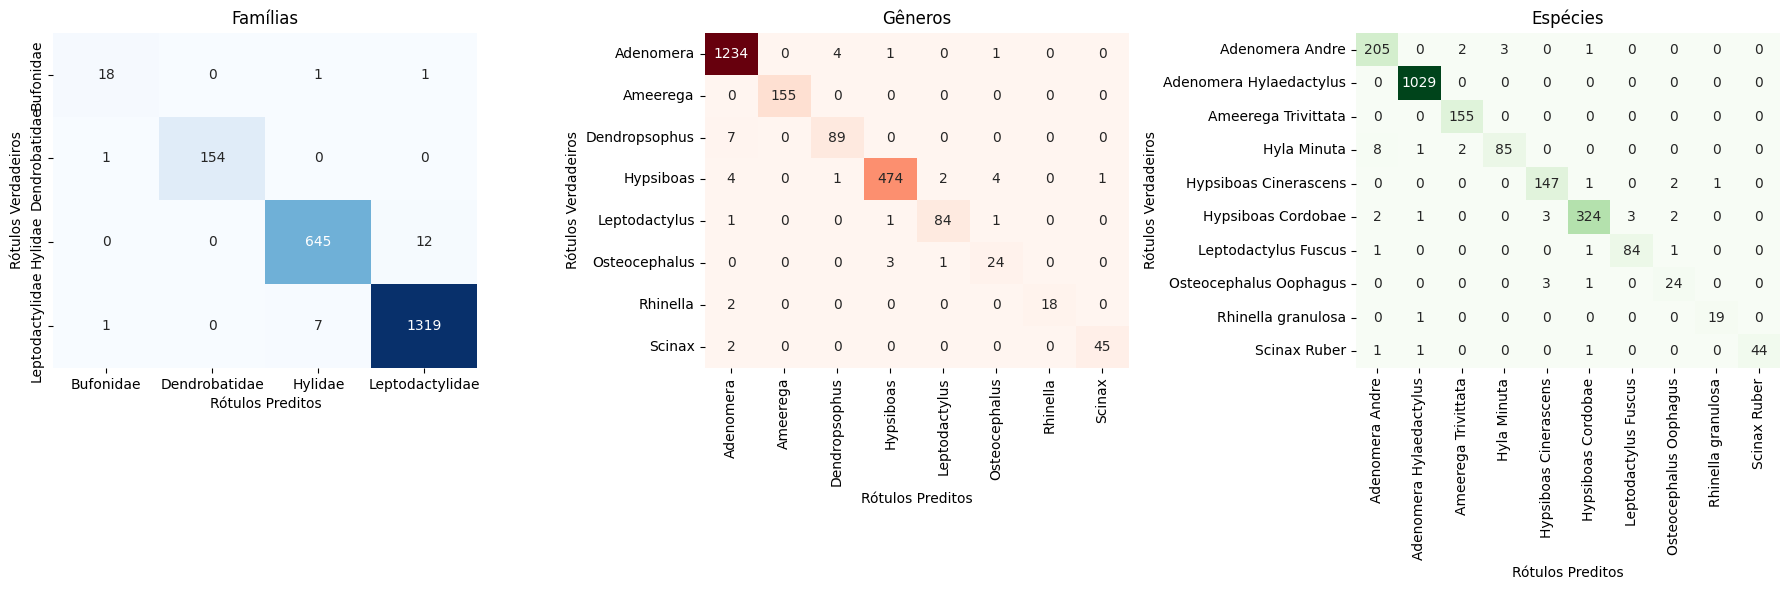

In [ ]:
# Criar subplots para organizar as visualizações lado a lado
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotar as matrizes de confusão para cada categoria
sns.heatmap(matriz_confusao_familias, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=nomes_familias, yticklabels=nomes_familias, ax=axs[0])
axs[0].set_title('Famílias')
axs[0].set_xlabel('Rótulos Preditos')
axs[0].set_ylabel('Rótulos Verdadeiros')

sns.heatmap(matriz_confusao_generos, annot=True, fmt='d', cmap='Reds', cbar=False, xticklabels=nomes_generos, yticklabels=nomes_generos, ax=axs[1])
axs[1].set_title('Gêneros')
axs[1].set_xlabel('Rótulos Preditos')
axs[1].set_ylabel('Rótulos Verdadeiros')

sns.heatmap(matriz_confusao_especies, annot=True, fmt='d', cmap='Greens', cbar=False, xticklabels=nomes_especies, yticklabels=nomes_especies, ax=axs[2])
axs[2].set_title('Espécies')
axs[2].set_xlabel('Rótulos Preditos')
axs[2].set_ylabel('Rótulos Verdadeiros')

plt.tight_layout()
plt.show()